In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [80]:
#Import data for processing

filename = "./20-08-2020/SMC_4rose_weird.xlsx"
data = pd.read_excel(filename, 
                    names = ["globaltime","dt",'rb1x','rb1y','rb1z','rb2x','rb2y','rb2z',
                            'rb3x','rb3y','rb3z','rb4x','rb4y','rb4z','rb5x','rb5y','rb5z',
                            'rb6x','rb6y','rb6z','rb7x','rb7y','rb7z','rb8x','rb8y','rb8z',
                            'xd','yd','thetad'])
while data.iloc[0]['rb1z']==0.0:    
    data = data.drop(0)
    data.index-=1
      
data.iloc[0]['rb1z']        


100.080021425776

In [81]:
#calculate robot position at each point

#calculate the center of the robot
Adet = (data['rb1x']*(data['rb4y']-data['rb6y']) -
       data['rb1y']*(data['rb4x']-data['rb6x']) +
       data['rb4x']*data['rb6y']-data['rb6x']*data['rb4y'])

Bdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb6y']-data['rb4y'])  +
       (data['rb4x']**2+data['rb4y']**2)*(data['rb1y']-data['rb6y'])  +
       (data['rb6x']**2+data['rb6y']**2)*(data['rb4y']-data['rb1y']) )

Cdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb4x']-data['rb6x'])  +
       (data['rb4x']**2+data['rb4y']**2)*(data['rb6x']-data['rb1x'])  +
       (data['rb6x']**2+data['rb6y']**2)*(data['rb1x']-data['rb4x']) )

x_r = -Bdet/(2.*Adet)/1000.+Bdet[0]/(2.*Adet[0])/1000. #robot global position x in meters (adjusted to origin)
y_r = -Cdet/(2.*Adet)/1000.+Cdet[0]/(2.*Adet[0])/1000. #robot global position y in meters


x_mid = (data['rb1x']+data['rb8x'])/2./1000.+Bdet[0]/(2.*Adet[0])/1000. #calculate the midpoint of wheel 1 (adjusted to origin)
y_mid = (data['rb1y']+data['rb8y'])/2./1000.+Cdet[0]/(2.*Adet[0])/1000.

#rotate desired position to be in line with robot
#xd_rot =data['xd']*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))-data['yd']*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
#yd_rot =data['yd']*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))+data['xd']*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
xd_rot = data['xd']
yd_rot = data['yd']


xr_rot =x_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))+y_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
yr_rot =y_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))-x_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))


#set robot initial position to the origin
#x_r = x_r+Bdet[0]/(2.*Adet[0])/1000. #robot position x in meters starting at origin
#y_r = y_r+Cdet[0]/(2.*Adet[0])/1000. #robot global position y in meters  starting at origin
theta_r = np.arctan2(y_mid-y_r,x_mid-x_r) - np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]) #robot angle starting at 0

In [82]:
#cast robot info into a new dataframe

pdata = pd.DataFrame()
pdata.insert(0,"globaltime", data['globaltime'],True) #get global time
pdata.insert(1, "x_r", xr_rot,True) #get robot positions (adjusted to origin)
pdata.insert(2, "y_r", yr_rot,True)
pdata.insert(3, "theta_r", theta_r,True)

pdata.insert(4, "x_d", xd_rot,True) #get robot desired positions (adjusted for starting orientation)
pdata.insert(5, "y_d", yd_rot,True)
pdata.insert(6, "theta_d", data['thetad'],True)

pdata.insert(7,'e_x', pdata['x_r']-pdata['x_d']) #calculate the errors at each point
pdata.insert(7,'e_y', pdata['y_r']-pdata['y_d'])
pdata.insert(7,'e_theta', pdata['theta_r']-pdata['theta_d'])

#for i in range (1000,len(pdata['theta_r'])): #use to drop the last x amount of data
#    pdata = pdata.drop(i)

for i in range(0, 1000):
    pdata = pdata.drop(i)

In [83]:
RMSE_x = np.sqrt(sum(pdata['e_x']**2)/len(pdata['e_x']))
RMSE_y = np.sqrt(sum(pdata['e_y']**2)/len(pdata['e_y']))
RMSE_theta = np.sqrt(sum(pdata['e_theta']**2)/len(pdata['e_theta']))

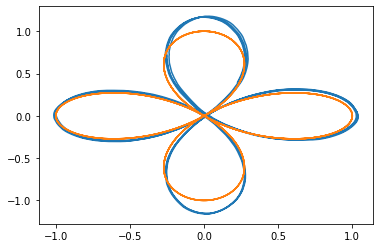

In [84]:
ax = plt.subplot(1,1,1)
#pdata['x_d'][0] = 0
ax.plot(pdata['x_r'],pdata['y_r'],pdata['x_d'],pdata['y_d'])
#ax.plot(pdata.iloc[0]['x_d'],pdata.iloc[0]['y_d'],linewidth=6)
#print(pdata.iloc[0]['x_d'])
#print(pdata.iloc[0]['y_d'])
#print(np.arctan2(y_mid[0],x_mid[0])*180/np.pi)
#plt.plot(pdata['x_r'],pdata['y_r'],pdata['x_d'],pdata['y_d'])
#plt.plot(pdata[0]['x_d'],pdata[0]['y_d'])
plt.show()

In [85]:
print(RMSE_x)
print(RMSE_y)
print(RMSE_theta)

0.17109477386963665
0.18616125329910235
0.012435120467845272


In [86]:
data.iloc[0]['rb1x']
-Bdet[0]/(2.*Adet[0])/1000.

0.20365221867249161

In [19]:
pdata['x_r']

0       0.000000
1       0.000016
2       0.000034
3       0.000015
4       0.000056
          ...   
1044    1.016957
1045    1.016929
1046    1.017142
1047    1.016921
1048    1.017153
Name: x_r, Length: 1049, dtype: float64